# iTEBD

In [3]:
import pyUni10 as uni10
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Construct the Hamiltonian

We construct the Hamiltonian for the transverse Ising model: 

\begin{equation}
H=-\sum_{\langle ij\rangle} \sigma_i^z\sigma_j^z +h \sum_i \sigma_i^x
\end{equation}



In [4]:


def matSp():
  spin = 0.5
  dim = int(spin * 2 + 1)
  return uni10.Matrix(dim, dim, [0, 1, 0, 0])

def matSm():
  spin = 0.5
  dim = int(spin * 2 + 1)
  return uni10.Matrix(dim, dim, [0, 0, 1, 0])

def matSz():
  spin = 0.5
  dim = int(spin * 2 + 1)
  return uni10.Matrix(dim, dim, [0.5, 0, 0, -0.5])

def transverseIsing(h):
    spin = 0.5
    sx = 0.5*(matSp()+matSm())
    sz = matSz()
    iden = uni10.Matrix(2,2, [1, 0, 0, 1])
    ham =uni10.otimes(2*sz,2*sz) +0.5*float(h)*(uni10.otimes(iden,2*sx)+uni10.otimes(2*sx,iden))
    dim = int(spin * 2 + 1)
    bdi = uni10.Bond(uni10.BD_IN, dim);
    bdo = uni10.Bond(uni10.BD_OUT, dim);
    H =  uni10.UniTensor([bdi, bdi, bdo, bdo], "TFIM")
    H.putBlock(ham)
    return H


## Helper functions

1. `bondcat(T,L,bidx)`: merge  UniTensors *T* and  *L* at bond *idx*
2. `bondrm(T,L,bidx)`: apply  $L^{-1}$ to bond *idx* of *T* 

In [5]:


def bondcat(T, L, bidx):
    labels = T.label();
    per_labels = list(T.label())
    per_labels.insert(0, per_labels.pop(bidx))
    inBondNum = T.inBondNum()
    T.permute(per_labels, 1)
    T.putBlock(L * T.getBlock())
    T.permute(labels, inBondNum)

def bondrm(T, L, bidx):
    invL = uni10.Matrix(L.row(), L.col(), True)
    for i in xrange(L.elemNum()):
        invL[i] = 0 if L[i] == 0 else 1.0 / L[i]
    bondcat(T, invL, bidx)


## Simultation parameters

* chi : bond dimension $\chi$
* delta: time step $\delta$ 
* N : number of iterations
* H : Hamiltonian

In [6]:
chi = 5
delta = 0.02
N = 1000
H = transverseIsing(1.2)

### Initialize the tensors

In [7]:
bdi_chi = uni10.Bond(uni10.BD_IN, chi)
bdo_chi = uni10.Bond(uni10.BD_OUT, chi)

# Gamma matrices: Gs=[Ga, Gb]
Gs = []
Gs.append(uni10.UniTensor([bdi_chi, bdo_chi, H.bond(2)], "Ga"))
Gs.append(uni10.UniTensor([bdi_chi, bdo_chi, H.bond(2)], "Gb"))
Gs[0].randomize(), Gs[1].randomize()

# Lambda matrices (diagonal): Ls=[La, Lb]
Ls = []
Ls.append(uni10.Matrix(chi, chi, True))  # Diagonal matrix
Ls.append(uni10.Matrix(chi, chi, True))  # Diagonal matrix
Ls[0].randomize(), Ls[1].randomize()

# Setup U=exp^{-delta H}
U = uni10.UniTensor(H.bond(), "U")
U.putBlock(uni10.takeExp(-delta, H.getBlock()))



In [8]:
Gs[0]

***************** Ga *****************
REAL

             ____________
            |            |
        0___|5          5|___1    
            |            |   
            |           2|___2    
            |            |   
            |____________|

================BONDS===============
IN : (U1 = 0, P = 0, 0)|5, Dim = 5
OUT: (U1 = 0, P = 0, 0)|5, Dim = 5
OUT: (U1 = 0, P = 0, 0)|2, Dim = 2

===============BLOCKS===============
--- (U1 = 0, P = 0, 0): 5 x 10 = 50, REAL

            0.016            0.564            0.549            0.261            0.658            0.259            0.767            0.926            0.963            0.173

            0.669            0.214            0.390            0.328            0.750            0.855            0.566            0.811            0.144            0.542

            0.562            0.569            0.154            0.432            0.793            0.826            0.894            0.349            0.298            0.775

     

In [9]:
Gs[1]

***************** Gb *****************
REAL

             ____________
            |            |
        0___|5          5|___1    
            |            |   
            |           2|___2    
            |            |   
            |____________|

================BONDS===============
IN : (U1 = 0, P = 0, 0)|5, Dim = 5
OUT: (U1 = 0, P = 0, 0)|5, Dim = 5
OUT: (U1 = 0, P = 0, 0)|2, Dim = 2

===============BLOCKS===============
--- (U1 = 0, P = 0, 0): 5 x 10 = 50, REAL

            0.645            0.181            0.928            0.012            0.756            0.194            0.289            0.706            0.753            0.456

            0.644            0.069            0.574            0.883            0.837            0.942            0.517            0.057            0.902            0.457

            0.589            0.458            0.843            0.306            0.343            0.197            0.397            0.163            0.963            0.161

     

In [10]:
Ls[0]

5 x 5 = 5, REAL, Diagonal

            0.450            0.000            0.000            0.000            0.000

            0.000            0.336            0.000            0.000            0.000

            0.000            0.000            0.233            0.000            0.000

            0.000            0.000            0.000            0.826            0.000

            0.000            0.000            0.000            0.000            0.447


In [11]:
Ls[1]

5 x 5 = 5, REAL, Diagonal

            0.915            0.000            0.000            0.000            0.000

            0.000            0.510            0.000            0.000            0.000

            0.000            0.000            0.412            0.000            0.000

            0.000            0.000            0.000            0.950            0.000

            0.000            0.000            0.000            0.000            0.288


### Main update loop

In [12]:
Elist=[]
for step in range(N):
    # Construct theta
    A = step % 2
    B = (step + 1) % 2
    bondcat(Gs[A], Ls[A], 1)
    bondcat(Gs[A], Ls[B], 0)
    bondcat(Gs[B], Ls[B], 1)
    Gs[A].setLabel([-1, 3, 1])
    Gs[B].setLabel([3, -3, 2])
    U.setLabel([1, 2, -2, -4])
    theta = uni10.contract(Gs[A], Gs[B], True) # Gs[A], Gs[B] is permuted after the execution
    Ntheta = theta
    theta *= U;
    theta.permute([-1, -2, -3, -4], 2)

    # SVD
    svd = theta.getBlock().svd()

    # Truncation
    sv = svd[1]
    norm = sv.resize(chi, chi).norm()
    sv *= 1.0 / norm;
    Ls[A] = sv
    Gs[A].putBlock(svd[0].resize(svd[0].row(), chi))
    Gs[B].putBlock(svd[2].resize(chi, svd[2].col()))
    Gs[A].permute([-1, 3, 1], 1)
    bondrm(Gs[A], Ls[B], 0)
    bondrm(Gs[B], Ls[B], 1)  
    val = (theta * theta)[0]
    norm =(Ntheta * Ntheta )[0]
    E = -np.log(val) / delta / 2
    E = E/norm
    if step % 100 == 0:
        print 'E=',E
    Elist.append(E)
print E

E= -5.07636356874
E= -1.38610330842
E= -1.40718584727
E= -1.41365479864
E= -1.41668674857
E= -1.41819179135
E= -1.41892299111
E= -1.41926803534
E= -1.41942757257
E= -1.41950048162
-1.41953338156


(-2, 1)

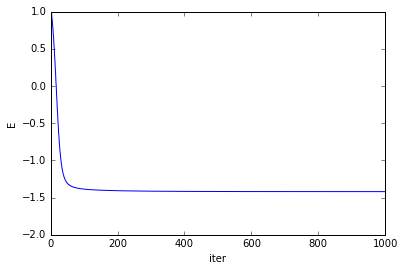

In [13]:
plt.plot(Elist)
plt.xlabel('iter')
plt.ylabel('E')
plt.ylim([-2,1])